# Project analysis

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import git

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), os.pardir, os.pardir)))
print(os.path.realpath(os.path.join(os.getcwd(), os.pardir, os.pardir)))

from gitlytic import settings
from gitlytic.dataloader import load_project_commit_df
from gitlytic.project import get_project_output_dir_by_name, get_project_path

/home/skupsala/code/gitlytic


Set your project and repo config here

In [2]:
PROJECT_NAME = 'datascience'

Load repo TSV file

In [3]:
df = load_project_commit_df(get_project_path(PROJECT_NAME))

Loading commits dataframe for datascience


In [4]:
df.set_index(['repo_name', 'author_email', 'commit_hash'], drop=False, inplace=True)
df.head()

repo_name  \
repo_name author_email                     commit_hash                                          
seaborn   mwaskom@users.noreply.github.com 88c49ef6c14ca69def8195f03d467915b3b0597c   seaborn   
          mwaskom@nyu.edu                  b882bf121932739a9fe237d3fdab9f5cee975a88   seaborn   
                                           685ca8b14ca05c8b5f7cc88fc82708a8f0a492fb   seaborn   
                                           596d4ca14d6b8193f239966b497e9dfa96603aec   seaborn   
                                           5574f5174a5b1026b5dc3aa69f8dcd50979f3137   seaborn   

                                                                                                                  commit_hash  \
repo_name author_email                     commit_hash                                                                          
seaborn   mwaskom@users.noreply.github.com 88c49ef6c14ca69def8195f03d467915b3b0597c  88c49ef6c14ca69def8195f03d467915b3b0597c   
          mwaskom@nyu.edu                  b882bf121932739a9fe237d3fdab9f5cee975a88  b882bf121932739a9fe237d3fdab9f5cee975a88   
                                           685ca8b14ca05c8b5f7cc88fc82708a8f0a492fb  685ca8b14ca05c8b5f7cc88fc82708a8f0a492fb   
                                           596d4ca14d6b8193f239966b497e9dfa96603aec  596d4ca14d6b8193f239966b497e9dfa96603aec   
                                           5574f5174a5b1026b5dc3aa69f8dcd50979f3137  5574f5174a5b1026b5dc3aa69f8dcd50979f3137   

                                                                                        author_name  \
repo_name author_email                     commit_hash                                                
seaborn   mwaskom@users.noreply.github.com 88c49ef6c14ca69def8195f03d467915b3b0597c  Michael Waskom   
          mwaskom@nyu.edu                  b882bf121932739a9fe237d3fdab9f5cee975a88  Michael Waskom   
                                           685ca8b14ca05c8b5f7cc88fc82708a8f0a492fb  Michael Waskom   
                                           596d4ca14d6b8193f239966b497e9dfa96603aec  Michael Waskom   
                                           5574f5174a5b1026b5dc3aa69f8dcd50979f3137  Michael Waskom   

                                                                                                         author_email  \
repo_name author_email                     commit_hash                                                                  
seaborn   mwaskom@users.noreply.github.com 88c49ef6c14ca69def8195f03d467915b3b0597c  mwaskom@users.noreply.github.com   
          mwaskom@nyu.edu                  b882bf121932739a9fe237d3fdab9f5cee975a88                   mwaskom@nyu.edu   
                                           685ca8b14ca05c8b5f7cc88fc82708a8f0a492fb                   mwaskom@nyu.edu   
                                           596d4ca14d6b8193f239966b497e9dfa96603aec                   mwaskom@nyu.edu   
                                           5574f5174a5b1026b5dc3aa69f8dcd50979f3137                   mwaskom@nyu.edu   

                                                                                            author_date  \
repo_name author_email                     commit_hash                                                    
seaborn   mwaskom@users.noreply.github.com 88c49ef6c14ca69def8195f03d467915b3b0597c 2017-11-30 22:03:11   
          mwaskom@nyu.edu                  b882bf121932739a9fe237d3fdab9f5cee975a88 2017-11-30 21:15:36   
                                           685ca8b14ca05c8b5f7cc88fc82708a8f0a492fb 2017-11-30 20:14:24   
                                           596d4ca14d6b8193f239966b497e9dfa96603aec 2017-11-30 03:32:49   
                                           5574f5174a5b1026b5dc3aa69f8dcd50979f3137 2017-11-30 03:25:21   

                                                                                     committer_name  \
repo_name author_email                     commit_hash                       

## Project overview
TODO
- TOP 10 contributors (3months, 2weeks)
  * How many commits
  * Percentage of commits
- Commmits per week chart over X weeks
- Commit message length distribution over all commits
- LOC over time
- Author count over time
- New authors per week for last X weeks
- Files over time
- Directories over time
- Fix commits over time

#### Commit and author count

In [5]:
total_commit_count = len(df)
print("Commit count: {}".format(total_commit_count))
total_author_count = df['author_email'].nunique()
print("Author count: {}".format(total_author_count))

Commit count: 110377
Author count: 4317


In [6]:
def get_top_contributors(df, top_count=10):
    commit_count = len(df)
    top_committers = df.groupby('author_email').size().sort_values(ascending=False)[:top_count].to_frame(name='commit_count')
    top_committers['percentage_of_commits'] = (top_committers['commit_count'] / commit_count) * 100.0
    return top_committers

In [7]:
repos_by_hour = {}
for repo_name, repo_df in df.groupby(level=0):
    print()
    print('-----------------------------------------------------------')
    print('Repo: {}'.format(repo_name))
    print('Commits: {}'.format(len(repo_df)))
    print('Authors: {}'.format(repo_df['author_email'].nunique()))
    oldest_commit = repo_df.iloc[-1]
    age_delta = datetime.now() - oldest_commit.author_date.to_pydatetime()
    age_delta_years = age_delta.days // 366 # This is not exact - precise enough for this purpose
    print('Age: {years} year(s) and {days} day(s)'.format(years=age_delta_years, days=(age_delta.days-age_delta_years*365)))
    print('First commit was written {} by {}'.format(oldest_commit.author_date.to_pydatetime(), oldest_commit.author_name))
    print('For nostalgy, here it is:')
    print(oldest_commit.subject)
    print()
    print('Since that a lot have happened...')
    TOP_COUNT = 5
    print('Here you see top {} contributors portion of the contributions'.format(TOP_COUNT))
    repo_top_contributors = get_top_contributors(repo_df, top_count=TOP_COUNT)
    print(repo_top_contributors.sum())
    print(repo_top_contributors)
    print()
    print('Last three months top {} contributors'.format(TOP_COUNT))
    last_three_months_commits = repo_df[repo_df['author_date'] >= (datetime.today() - timedelta(days=3 * 30))]
    last_three_months_top_contributors = get_top_contributors(last_three_months_commits, top_count=TOP_COUNT)
    print(last_three_months_top_contributors)
    print()
    print('Last two weeks top {} contributors'.format(TOP_COUNT))
    last_two_weeks_commits = repo_df[repo_df['author_date'] >= (datetime.today() - timedelta(days=14))]
    last_two_weeks_top_contributors = get_top_contributors(last_two_weeks_commits, top_count=TOP_COUNT)
    print(last_two_weeks_top_contributors)
    author_date_index = pd.DatetimeIndex(repo_df['author_date'])
    print(author_date_index.hour)
    repos_by_hour[repo_name] = repo_df.groupby(author_date_index.hour)['author_email'].count()
    


-----------------------------------------------------------
Repo: matplotlib
Commits: 23714
Authors: 819
Age: 14 year(s) and 237 day(s)
First commit was written 2003-05-12 15:20:38 by John Hunter
For nostalgy, here it is:
The new matplotlib hierarchy
['__add__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__rsub__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', 'astimezone', 'combine', 'ctime', 'date', 'day', 'dst', 'fromordinal', 'fromtimestamp', 'hour', 'isocalendar', 'isoformat', 'isoweekday', 'max', 'microsecond', 'min', 'minute', 'month', 'now', 'replace', 'resolution', 'second', 'strftime', 'strptime', 'time', 'timestamp', 'timetuple', 'timetz', 'today', 'toordinal', 'tzinfo', 'tzname', 'utcfromtimestamp', 'utcnow', 'utcoffset', 'utctimetuple', 'weekday', 'year']
Non

/home/skupsala/code/gitlytic/gl/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: 'author_email' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


### Commits over time

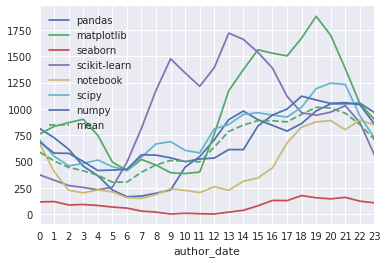

In [8]:
for repo_name, by_hour in repos_by_hour.items():
    ax = by_hour.plot(xticks=np.arange(24), label=repo_name)
    ax.legend()
mean_by_hour_df = pd.concat(list(repos_by_hour.values()), axis=1)
ax = mean_by_hour_df.mean(axis=1).plot(xticks=np.arange(24), label='mean', style='--')
ax.legend()

### Subject line distributions

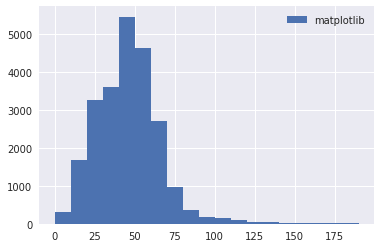

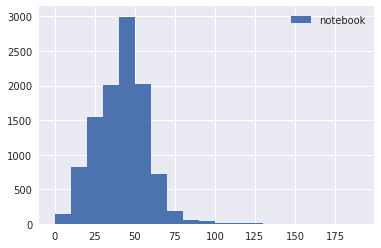

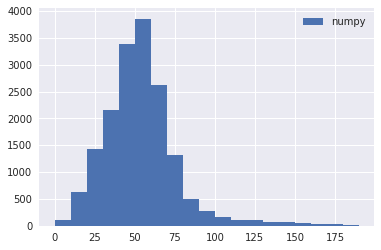

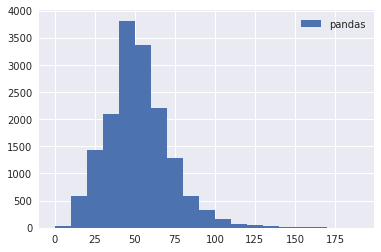

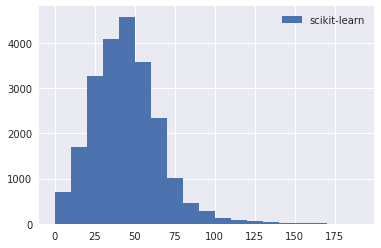

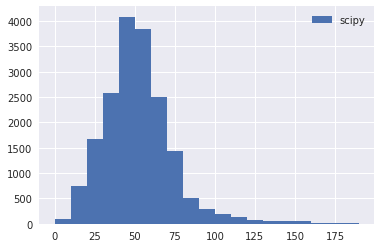

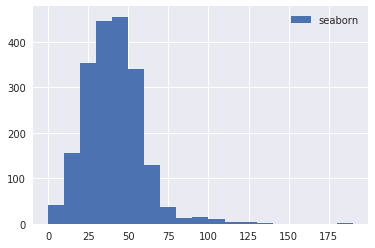

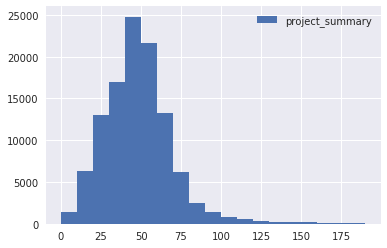

In [9]:
for repo_name, repo_df in df.groupby(level=0):
    plt.figure()
    s = pd.Series(repo_df['subject'].str.len().values)
    ax = s.dropna().hist(bins=[n for n in range(0, 200, 10)], label=repo_name)
    ax.legend()

plt.figure()
s = pd.Series(df['subject'].str.len().values)
ax = s.dropna().hist(bins=[n for n in range(0, 200, 10)], label='project_summary')
ax.legend()